In [31]:
import numpy as np
import os
import os.path
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import defaultdict
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(0)

## Preprocessing

In [2]:
Captchas_PATH = Path('labeled_captchas')

In [3]:
CAPTCHA_LENGTH = 5

In [5]:
SYMBOLS = list(string.ascii_uppercase + string.digits)
N_Classes = len(SYMBOLS)

In [12]:
label_encoder = LabelEncoder()
label_encoder.fit(SYMBOLS)
stoi = {symb: label_encoder.transform([symb])[0] for symb in SYMBOLS}
itos = {value: key for (key,value) in stoi.items()}

In [13]:
itos

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z'}

Download data and correcting errors

In [14]:
X, y = [], []
for fname in Captchas_PATH.iterdir():
    img = cv2.imread(str(fname),1) #Read color image
    #img = img[10:130,:,:]
    #img = cv2.resize(img,(120,120))
    img = cv2.resize(img,(150,150))
    label = fname.name[:-4].upper()
    if len(label) == 5:
        X.append(img)
        y.append(label)
    else:
        print(label)

5A4B
B20EB0
27AA
D780
E1AEEF
FEE0
EC5F
9B07
E93E


It turns out that many images from the list were simply incorrectly labeled.

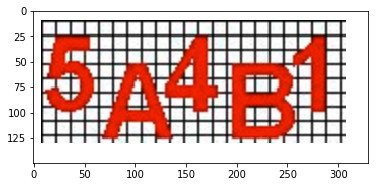

In [15]:
image_name = '5A4B.png'
image_path = Captchas_PATH/image_name
img2 = cv2.imread(str(image_path),1)
plt.imshow(img2);

In [16]:
y = [[stoi[symb] for symb in label] for label in y]

In [17]:
# splitting the samples into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2,random_state = 1)

In [18]:
len(X_train), len(X_test)

(798, 200)

In [19]:
#Select validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = .05,random_state = 1)

In [20]:
len(X_val)

40

Convert to np.array

In [22]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [23]:
X_train.shape

(758, 150, 150, 3)

Calculate means and stds across RGB channels for image normalization.

In [24]:
means = [X_train[:,:,:,i].mean()/255 for i in range(3)]
stds = [X_train[:,:,:,i].std()/255 for i in range(3)]
means, stds

([0.7471896482544939, 0.7110150716539915, 0.6721225189553981],
 [0.32122075460556254, 0.35321328969183013, 0.3677937843705539])

In [25]:
preproc_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=means,std=stds),
    ])

In [26]:
X_train = [preproc_transforms(img) for img in X_train]
X_val = [preproc_transforms(img) for img in X_val]
X_test = [preproc_transforms(img) for img in X_test]

Convert to Tensors for creating a TensorDataset. It was a not a good idea.

In [27]:
X_train, y_train = torch.stack(X_train), torch.LongTensor(y_train)
X_val, y_val = torch.stack(X_val), torch.LongTensor(y_val)
X_test, y_test = torch.stack(X_test), torch.LongTensor(y_test)

Create Data Loaders

In [28]:
train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


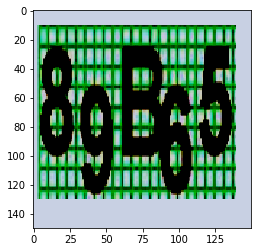

In [29]:
sample_data = next(iter(train_loader))
plt.imshow(sample_data[0][0].permute(1,2,0));

## Darknet

In [32]:
def ConvLayer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1))

In [33]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=ConvLayer(ni, ni//2, ks=1)
        self.conv2=ConvLayer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add(self.conv2(self.conv1(x)))

In [34]:
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [35]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [ConvLayer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]


    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [ConvLayer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten()]
        self.layers = nn.Sequential(*layers)
        self.symbol_layers = nn.ModuleList()
        for i in range(CAPTCHA_LENGTH):
            linear_layer = nn.Sequential(nn.Linear(nf, num_classes),
                                         nn.Dropout(p=0.5),
                                         nn.ReLU()
                                        )
            self.symbol_layers.append(linear_layer)
         
    def forward(self, x): 
        x = self.layers(x)
        return [F.log_softmax(self.symbol_layers[i](x)) for i in range(CAPTCHA_LENGTH)]

In [36]:
def loss_function(output,target):
    loss_val = 0
    for i in range(CAPTCHA_LENGTH):
        loss_val += F.nll_loss(output[i],target[:,i])
    return loss_val

## Training

In [37]:
model = Darknet([1, 2, 4, 6, 3], num_classes=N_Classes, nf=32)
model.cuda()

Darknet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): ResLayer(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stat

In [38]:
optimizer = optim.Adam(model.parameters(),lr=1e-2)

Set up learning rate scheduler

In [39]:
from torch.optim.lr_scheduler import LambdaLR

In [40]:
scheduler = LambdaLR(optimizer, lr_lambda= lambda epoch: 0.1**((epoch%300)/300))

In [41]:
def training(epoch,model,data_loader):
    for batch_idx , (data,target) in enumerate(data_loader):
        data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output,target)
        
        loss.backward()
        scheduler.step()
        return loss

In [42]:
model.train()
for epoch in range(1,501):
    train_loss = training(epoch,model,train_loader)
    print("\rEpoch: {}, Train loss: {}" .format(epoch,train_loss),end='')
    if epoch % 100 == 0:
        with torch.no_grad():
            model.eval()
            output = model(val.tensors[0].cuda())
            val_loss = loss_function(output,val.tensors[1].cuda())
            print("\rEpoch: {}, Train loss: {}, Val loss: {}" .format(epoch,train_loss,val_loss))
        model = model.train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 100, Train loss: 18.745180130004883, Val loss: 17.906879425048828
Epoch: 200, Train loss: 18.771949768066406, Val loss: 17.920246124267578
Epoch: 300, Train loss: 18.606298446655273, Val loss: 17.927976608276367
Epoch: 400, Train loss: 18.82421875, Val loss: 17.96400260925293
Epoch: 500, Train loss: 18.647062301635742, Val loss: 18.03982162475586


## Testing

In [44]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    count = 0
    for batch_idx , (data,target) in enumerate(test_loader):
        count += 1
        data, target = data.cuda(),target.cuda()
        output = model(data)
        test_loss += loss_function(output,target)
print("Test loss: {}" .format(test_loss/count))

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 18.129013061523438


Check for a test image

In [43]:
test_sample = next(iter(test_loader))
data , target = test_sample
test_img, label = data[0].permute(1,2,0).numpy(),target[0].numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


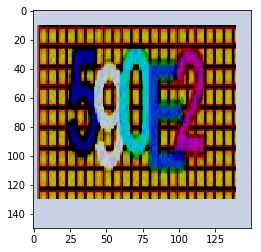

In [45]:
plt.imshow(test_img);

Getting prediction

In [46]:
with torch.no_grad():
    model.eval()
    output = model(data[0][None].cuda())

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [57]:
pred = [output[i].data.max(dim=1)[1].cpu() for i in range(CAPTCHA_LENGTH)]

In [58]:
pred = [symbol.numpy()[0] for symbol in pred]
pred

[23, 6, 31, 31, 28]

In [59]:
pred = [itos[integ] for integ in pred]
pred

['N', '6', 'V', 'V', 'S']